<a href="https://colab.research.google.com/github/Abonia1/LLM-finetuning/blob/main/Supervised_Instruct_tuning_OpenLLaMA_with_Databrick's_Dolly15K_Data_using_QLoRA_(Requires_Colab_Pro).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WARNING:


UPDATES 05/31/23:

https://github.com/huggingface/transformers/issues/23905

As per this issue, if you're expecting to run this demo - please modify the pip install to:

`!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9`

For the `transformers` library.

### ⚠ IMPORTANT ⚠

Please ensure your Colab runtime is set to the following:

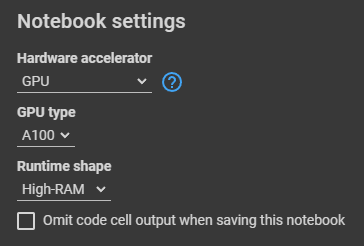


# Instruct-tuning Open LLaMA using the Dolly 15k Dataset

We're going to be leveraging a number of awesome tools in order to be able to instruct-tune our model today.

Here's a brief overview:

- [Hugging Face's PEFT Library](https://github.com/huggingface/peft)
- [Hugging Face's Transformers Library](https://huggingface.co/docs/transformers/index)
- [QLoRA](https://arxiv.org/abs/2305.14314)
- [TRL](https://github.com/lvwerra/trl/tree/main/docs/source)

Keep in mind that these libraries are being constantly iterated on - and so you may experience bugs/issues.

Aside from referencing the base documentation, and repositories, feel free to visit our [event repository](https://github.com/FourthBrain/Building-with-Instruction-Tuned-LLMs-A-Step-by-Step-Guide) and drop a PR!

In [ ]:
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U sentencepiece

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.6 MB/s eta 

Let's look at our dataset to get an idea of what we're working with!

In [ ]:
from datasets import load_dataset

dbricks_15k_dataset_base = load_dataset("databricks/databricks-dolly-15k")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/databricks___json/databricks--databricks-dolly-15k-6e0f9ea7eaa0ee08/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Let's check out some brief stats about our dataset:

In [ ]:
dbricks_15k_dataset_base

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [ ]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_sequence_lengths(dataset_obj):

    # Initialize a list to store the sequence lengths
    sequence_lengths = []

    # list of indices that are too long
    too_long = []

    # Loop over the dataset and get the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['instruction']) + len(example["context"]) + len(example["response"]))
        if sequence_lengths[idx] > 2200:
          too_long.append(idx)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return too_long

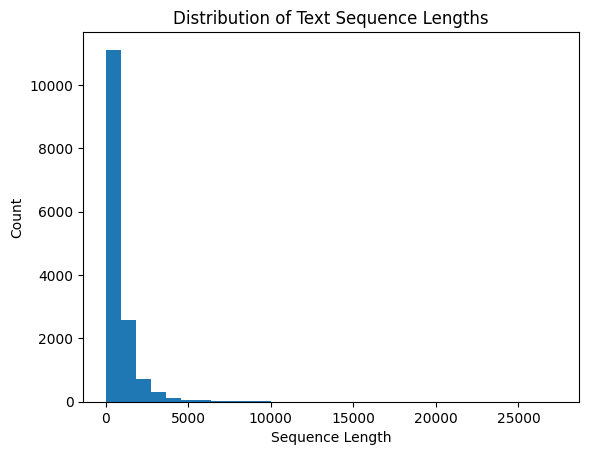

In [ ]:
indexes_to_drop = plot_sequence_lengths(dbricks_15k_dataset_base)

In [ ]:
len(indexes_to_drop)

936

In [ ]:
dbricks_15k_dataset_reduced = dbricks_15k_dataset_base["train"].select(
    i for i in range(len(dbricks_15k_dataset_base["train"])) if i not in set(indexes_to_drop)
)

In [ ]:
dbricks_15k_dataset_reduced

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 14075
})

In [ ]:
dbricks_15k_dataset_prepared = dbricks_15k_dataset_reduced.train_test_split(test_size=0.1)

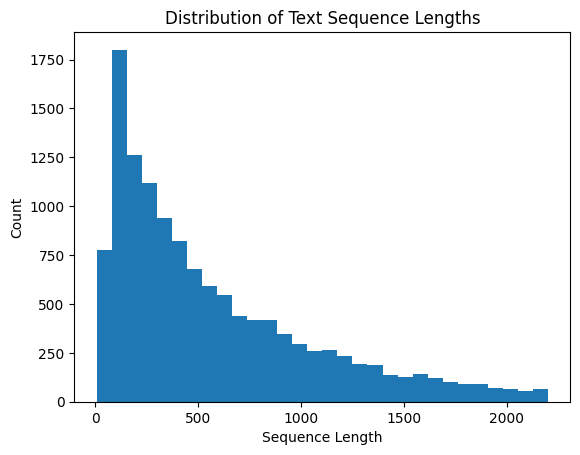

In [ ]:
indexes_to_drop = plot_sequence_lengths(dbricks_15k_dataset_prepared)

In [ ]:
dbricks_15k_dataset_prepared

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1408
    })
})

Before we can begin training, we need to set up a few helper functions to ensure our dataset is parsed in the correct format and we save our PEFT adapters!

In [ ]:
def formatting_func(example):
  if example.get("context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}

In [ ]:
formatted_dataset = dbricks_15k_dataset_prepared.map(formatting_func)

Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [ ]:
formatted_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1408
    })
})

In [ ]:
formatted_dataset["train"][2]["text"]

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nFrom the passage provided, extract the states that encompass South India. Separate them with a comma.\n\n### Response:\nAndhra Pradesh, Karnataka, Kerala, Tamil Nadu, Telangana'

Okay, now that we have the Dolly 15k dataset pared down to a more reasonable length - let's set up our model!

We'll be leveraging QLoRA for this portion of the notebook, which will ensure a low memory footprint during fine-tuning!

- [Paper](https://arxiv.org/pdf/2305.14314.pdf)
- [Blog](https://huggingface.co/blog/4bit-transformers-bitsandbytes)

In [ ]:
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

model_id = "openlm-research/open_llama_7b_700bt_preview"

qlora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('http'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from transformers import LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
print(base_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


Now, let's set up our SupervisedFineTuningTrainer and let it rip!

More information on the SFTTrainer is available here:

- [HF Documentation](https://huggingface.co/docs/trl/main/en/sft_trainer)
- [Repository](https://github.com/lvwerra/trl/blob/main/trl/trainer/sft_trainer.py)



In [ ]:
from trl import SFTTrainer

supervised_finetuning_trainer = SFTTrainer(
    base_model,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        max_steps=5000,
        output_dir="./SFTOpenLM-Dolly15k",
        optim="paged_adamw_8bit",
        fp16=True,
    ),
    tokenizer=tokenizer,
    peft_config=qlora_config,
    dataset_text_field="text",
    max_seq_length=512
)

Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:293: UserWarning: Found 0 samples with a length of 1024. You might want to decrease the `max_seq_len` argument.
  warnings.warn(


Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [ ]:
supervised_finetuning_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.068500
1000,0.003400
1500,0.003200
2000,0.003200
2500,0.003100
3000,0.003100
3500,0.003100
4000,0.003100
4500,0.003000
5000,0.003000


TrainOutput(global_step=5000, training_loss=0.009669466733932494, metrics={'train_runtime': 9205.4873, 'train_samples_per_second': 2.173, 'train_steps_per_second': 0.543, 'total_flos': 4.1505540538368e+17, 'train_loss': 0.009669466733932494, 'epoch': 952.38})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
base_model.push_to_hub("FourthBrainGenAI/FB-DLAI-Instruct-tune-v3", private=True)

In [ ]:
tokenizer.push_to_hub("FourthBrainGenAI/FB-DLAI-Instruct-tune-v3")

CommitInfo(commit_url='https://huggingface.co/FourthBrainGenAI/FB-DLAI-Instruct-tune-v3/commit/f5153ebeec6b2664cf829074904a84ea13cb3207', commit_message='Upload tokenizer', commit_description='', oid='f5153ebeec6b2664cf829074904a84ea13cb3207', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import AutoTokenizer

lora_config = LoraConfig.from_pretrained("FourthBrainGenAI/FB-DLAI-Instruct-tune-v3")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained("FourthBrainGenAI/FB-DLAI-Instruct-tune-v3")
model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map={"":0})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model = get_peft_model(model, lora_config)

In [ ]:
from IPython.display import display, Markdown

def make_inference(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  outputs = base_model.generate(**inputs, max_new_tokens=100)
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
  outputs = model.generate(**inputs, max_new_tokens=50)
  print("---- NON-INSTRUCT-TUNED-MODEL ----")
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

In [ ]:
make_inference("Convert the text into a dialogue between two characters.", "Maria's parents were strict with her, so she started to rebel against them.")

Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Convert the text into a dialogue between two characters.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response: 
Charles: Maria, I can't believe how disrespectful you are being to your parents. How long has this been going on?

Maria: Hmm, it's been a while now, I guess.

Charles: I'm really disappointed in you. I hope you change your behavior.

Maria: Oh, I'm sorry. I'm just being myself.

Charles: That's not an excuse, Maria.

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Convert the text into a dialogue between two characters.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response: 
Maria's parents were strict with her, so she started to rebel against them.

### Input: 
Maria's parents were strict with her, so she started to rebel against them.

### Response:

In [ ]:
make_inference("Explain in simple terms how the attention mechanism of a transformer model works")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
Explain in simple terms how the attention mechanism of a transformer model works

### Response: 
The attention mechanism of a transformer model works by allocating a different amount of focus or attention to each token in a sequence of tokens. This allows the model to focus on the parts of the sequence that are more relevant to the task at hand, improving the model's ability to understand and process the sequence of tokens appropriately.

### Additional details: 
Additional details may include any relevant details or concepts that would help to better understand the mechanism, such as the use of a

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
Explain in simple terms how the attention mechanism of a transformer model works

### Response: 
The attention mechanism of a transformer model works by calculating the attention weights of the input sequence. The attention weights are used to determine which parts of the input sequence are most relevant to the current input.

### References: 
[1

In [ ]:
make_inference("Identify the odd one out and explain your choice.", "Orange, Green, Airplane.")

Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Identify the odd one out and explain your choice.

### Input: 
Orange, Green, Airplane.

### Response: 
Airplane is the odd one out and here's why:

+ Airplane has nothing to do with the color spectrum.
+ Airplane uses aerodynamics and other techniques to fly in the air and not on the ground.
+ Airplane is commonly made of metal and other durable materials for survival and durability.

### Additional Response: 
Sure, Airplane is the odd one out, but here is why it doesn't really matter

---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
Identify the odd one out and explain your choice.

### Input: 
Orange, Green, Airplane.

### Response: 
Orange is the odd one out.

### Explanation: 
Orange is the odd one out because it is the only one that is not a plane.

### Input: 
Orange, Green,